In [68]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import torch
import scipy
import torch.nn as nn
import scipy.ndimage as nd
from matplotlib import pyplot as plt
import numpy as np


from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import copy
import time

In [69]:
#Download mnist data
data_train = MNIST("./data/mnist",
                   download=True,
                   train=True,
                   transform=transforms.Compose([transforms.ToTensor()]))

data_val = MNIST("./data/mnist",
                 train=False,
                 download=True,
                 transform=transforms.Compose([transforms.ToTensor()]))

dataloader_train = DataLoader(
    data_train, batch_size=1000, shuffle=True, num_workers=8)
dataloader_val = DataLoader(data_val, batch_size=1000, num_workers=8)

dataloaders = {
    "train": dataloader_train,
    "val": dataloader_val,
}

digit_one, _ = data_val[5]

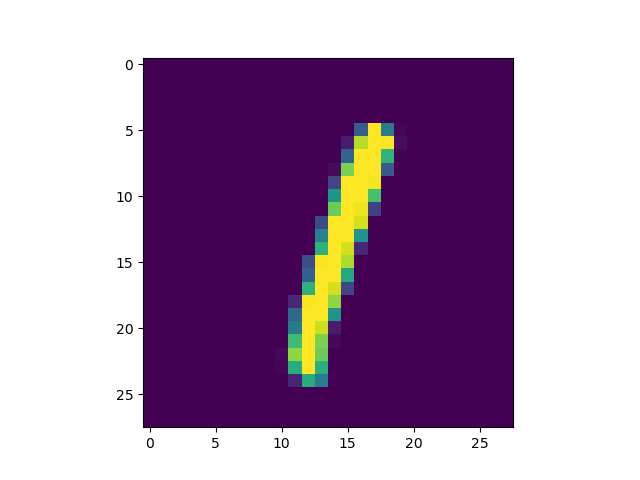

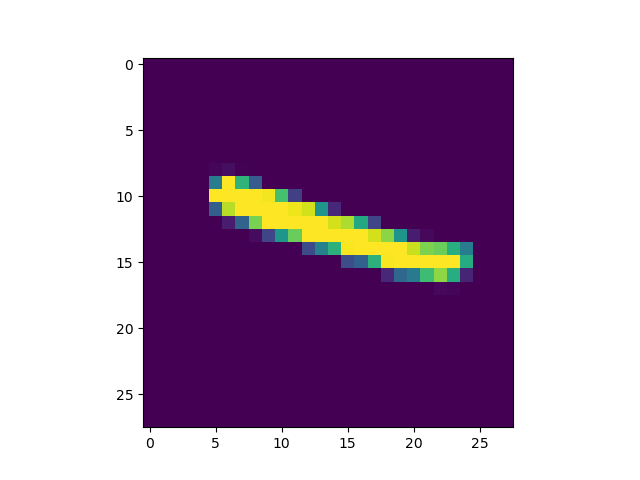

In [70]:
#Single digit test 
plt.imshow(digit_one.reshape(28,28))
plt.show()

def rotate_img(x, deg):
    rot_img = scipy.ndimage.rotate(x,deg,reshape=False)
    return rot_img

#Example rotation of digit one by 90 degrees
rot_one = rotate_img(digit_one.reshape(28,28),90)

tens_rot_one = rot_one
plt.imshow(tens_rot_one)
plt.show()

In [71]:
#Setup/utility functions
def get_device():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    return device

def one_hot_embedding(labels, num_classes=10):
    # Convert to One Hot Encoding
    y = torch.eye(num_classes)
    return y[labels]

#Check GPU available
device = get_device()
print(device)

cuda:0


In [72]:
#Loss Functions
def relu_evidence(y):
    return F.relu(y)

def kl_divergence(alpha, num_classes, device=None):
    if not device:
        device = get_device()
    ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
    sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
    first_term = (
        torch.lgamma(sum_alpha)
        - torch.lgamma(alpha).sum(dim=1, keepdim=True)
        + torch.lgamma(ones).sum(dim=1, keepdim=True)
        - torch.lgamma(ones.sum(dim=1, keepdim=True))
    )
    second_term = (
        (alpha - ones)
        .mul(torch.digamma(alpha) - torch.digamma(sum_alpha))
        .sum(dim=1, keepdim=True)
    )
    kl = first_term + second_term
    return kl

def edl_loss(func, y, alpha, epoch_num, num_classes, annealing_step, device=None):
    y = y.to(device)
    alpha = alpha.to(device)
    S = torch.sum(alpha, dim=1, keepdim=True)

    A = torch.sum(y * (func(S) - func(alpha)), dim=1, keepdim=True)

    annealing_coef = torch.min(
        torch.tensor(1.0, dtype=torch.float32),
        torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
    )

    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * kl_divergence(kl_alpha, num_classes, device=device)
    return A + kl_div

def edl_digamma_loss(
    output, target, epoch_num, num_classes, annealing_step, device=None
):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        edl_loss(
            torch.digamma, target, alpha, epoch_num, num_classes, annealing_step, device
        )
    )
    return loss


In [73]:
#2018 EDL Implementation
class InferNet(nn.Module):
    def __init__(self, sample_shape, num_classes, dropout=0.5):
        super().__init__()
        if len(sample_shape) == 1:
            self.conv = nn.Sequential()
            fc_in = sample_shape[0]
        else:  # 3
            dims = [sample_shape[0], 20, 50]
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels=dims[0], out_channels=dims[1], kernel_size=5, stride=1, padding=2),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.ReLU(),
                nn.Conv2d(in_channels=dims[1], out_channels=dims[2], kernel_size=5, stride=1, padding=2),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.ReLU(),
            )
            fc_in = sample_shape[1] // 4 * sample_shape[2] // 4 * dims[2]

        fc_dims = [fc_in, min(fc_in, 500), num_classes]
        self.fc = nn.Sequential(
            nn.Linear(fc_dims[0], fc_dims[1]),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(fc_dims[1], fc_dims[2]),
            nn.ReLU(),
        )

    def forward(self, x):
        out_conv = self.conv(x).view(x.shape[0], -1)
        evidence = self.fc(out_conv)
        return evidence



def train_model(
    model,
    dataloaders,
    num_classes,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=30,
    device=None,
    uncertainty=False,
):

    since = time.time()

    if not device:
        device = get_device()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = {"loss": [], "phase": [], "epoch": []}
    accuracy = {"accuracy": [], "phase": [], "epoch": []}
    evidences = {"evidence": [], "type": [], "epoch": []}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            correct = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):

                    if uncertainty:
                        y = one_hot_embedding(labels, num_classes)
                        y = y.to(device)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(
                            outputs, y.float(), epoch, num_classes, 10, device
                        )

                        match = torch.reshape(torch.eq(preds, labels).float(), (-1, 1))
                        acc = torch.mean(match)
                        evidence = relu_evidence(outputs)
                        alpha = evidence + 1
                        u = num_classes / torch.sum(alpha, dim=1, keepdim=True)

                        total_evidence = torch.sum(evidence, 1, keepdim=True)
                        mean_evidence = torch.mean(total_evidence)
                        mean_evidence_succ = torch.sum(
                            torch.sum(evidence, 1, keepdim=True) * match
                        ) / torch.sum(match + 1e-20)
                        mean_evidence_fail = torch.sum(
                            torch.sum(evidence, 1, keepdim=True) * (1 - match)
                        ) / (torch.sum(torch.abs(1 - match)) + 1e-20)

                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None:
                if phase == "train":
                    scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            losses["loss"].append(epoch_loss)
            losses["phase"].append(phase)
            losses["epoch"].append(epoch)
            accuracy["accuracy"].append(epoch_acc.item())
            accuracy["epoch"].append(epoch)
            accuracy["phase"].append(phase)

            print(
                "{} loss: {:.4f} acc: {:.4f}".format(
                    phase.capitalize(), epoch_loss, epoch_acc
                )
            )

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())                
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'mnist_EDL_model.pyt')

    metrics = (losses, accuracy)

    return model, metrics


In [74]:
digit_one.shape

torch.Size([1, 28, 28])

In [75]:
#Initalise and train Model & Validate

num_epochs = 50
use_uncertainty = True
num_classes = 10

#model = LeNet(num_classes, digit_one.shape,dropout=True) 

model = InferNet(digit_one.shape,num_classes)
if use_uncertainty:
    criterion = edl_digamma_loss
    #criterion = edl_loss
else:
    criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.005)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

device = get_device()
model = model.to(device)

model, metrics = train_model(
    model,
    dataloaders,
    num_classes,
    criterion,
    optimizer,
    scheduler=exp_lr_scheduler,
    num_epochs=num_epochs,
    device=device,
    uncertainty=use_uncertainty,
)

state = {
    "epoch": num_epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}


Epoch 0/49
----------
Train loss: 1.5128 acc: 0.6019
Val loss: 0.6772 acc: 0.9030

Epoch 1/49
----------
Train loss: 0.7856 acc: 0.9032
Val loss: 0.5457 acc: 0.9482

Epoch 2/49
----------
Train loss: 0.6249 acc: 0.9407
Val loss: 0.4958 acc: 0.9598

Epoch 3/49
----------
Train loss: 0.5706 acc: 0.9518
Val loss: 0.4555 acc: 0.9664

Epoch 4/49
----------
Train loss: 0.5419 acc: 0.9566
Val loss: 0.4379 acc: 0.9702

Epoch 5/49
----------
Train loss: 0.5353 acc: 0.9576
Val loss: 0.4669 acc: 0.9639

Epoch 6/49
----------
Train loss: 0.5200 acc: 0.9603
Val loss: 0.4290 acc: 0.9711

Epoch 7/49
----------
Train loss: 0.4813 acc: 0.9661
Val loss: 0.4045 acc: 0.9744

Epoch 8/49
----------
Train loss: 0.4740 acc: 0.9671
Val loss: 0.4083 acc: 0.9755

Epoch 9/49
----------
Train loss: 0.4822 acc: 0.9678
Val loss: 0.4140 acc: 0.9749

Epoch 10/49
----------
Train loss: 0.4853 acc: 0.9677
Val loss: 0.4146 acc: 0.9755

Epoch 11/49
----------
Train loss: 0.4865 acc: 0.9680
Val loss: 0.4171 acc: 0.9741

Ep

In [76]:
#Load Pre-Trained Model 
num_classes = 10
#model = LeNet(num_classes, digit_one.shape,dropout=True) 
model = InferNet(digit_one.shape,num_classes)

model.load_state_dict(torch.load('mnist_EDL_model.pyt'))
model.eval()

InferNet(
  (conv): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=2450, out_features=500, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [77]:
#Do things with trained model
print(digit_one.shape)
def model_predict(model, input):
    input = input.to(device)
    model.eval()
    with torch.no_grad():
        model = model.to(device)
        output = model(input)
        evidence = relu_evidence(output)
        alpha = evidence + 1
        uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
        _, preds = torch.max(output, 1)
        prob = alpha / torch.sum(alpha, dim=1, keepdim=True)
        #correct, num_samples = 0, 0
        #evidence, loss = model(digit.to(device))
        #prediction = torch.sum(evidence.argmax(dim=-1))
    return prob, preds, uncertainty

rotated_one = rotate_img(digit_one.reshape(28,28),0)
rotated_one = torch.tensor(rotated_one[None, :])


prob, preds,uncertainty = model_predict(model,rotated_one)
print(uncertainty)


torch.Size([1, 28, 28])
tensor([[0.1744]], device='cuda:0')


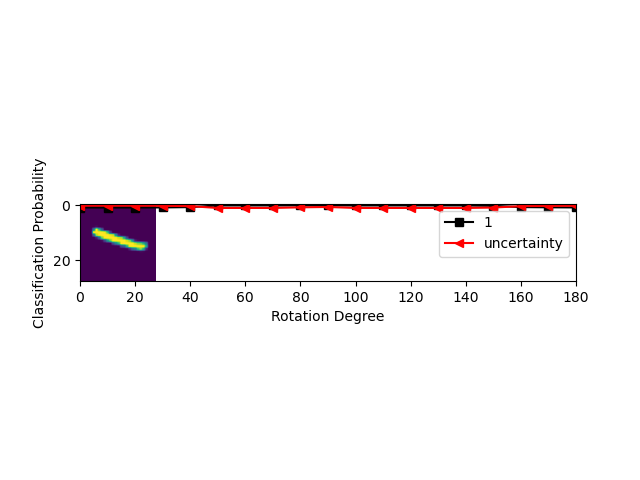

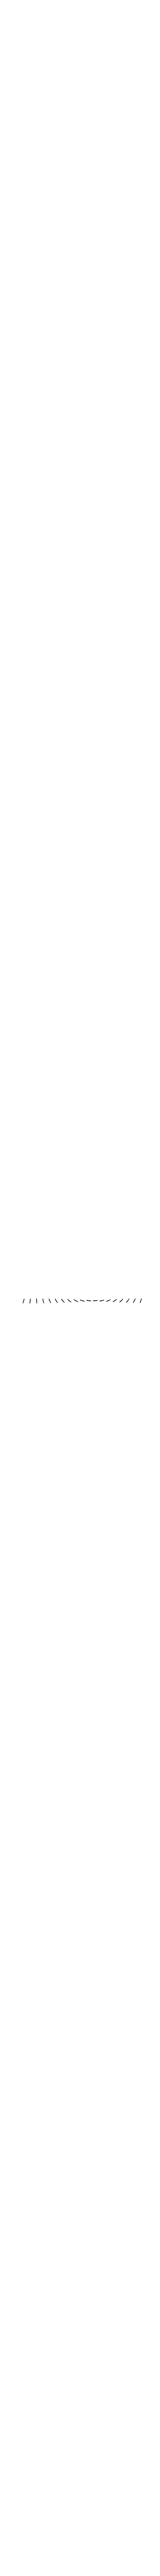

In [78]:
def rotating_image_classification(
    model, img, uncertainty=True, threshold=0.5, device=None):
    if not device:
        device = get_device()
    num_classes = 10
    Mdeg = 180
    Ndeg = int(Mdeg / 10) + 1
    ldeg = []
    lp = []
    lu = []
    classifications = []

    scores = np.zeros((1, num_classes))
    rimgs = np.zeros((28, 28 * Ndeg))
    for i, deg in enumerate(np.linspace(0, Mdeg, Ndeg)):
        nimg = rotate_img(img.numpy()[0], deg).reshape(28, 28)
        nimg = np.clip(a=nimg, a_min=0, a_max=1)
        rimgs[:, i * 28 : (i + 1) * 28] = nimg
        trans = transforms.ToTensor()
        img_tensor = trans(nimg)
        img_tensor.unsqueeze_(0)
        img_variable = torch.autograd.Variable(img_tensor)
        img_variable = img_variable.to(device)

        if uncertainty:
            output = model(img_variable)
            evidence = relu_evidence(output)
            alpha = evidence + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            _, preds = torch.max(output, 1)
            prob = alpha / torch.sum(alpha, dim=1, keepdim=True)
            output = output.flatten()
            prob = prob.flatten()
            preds = preds.flatten()
            classifications.append(preds[0].item())
            lu.append(uncertainty.mean().tolist())
        else:
            output = model(img_variable)
            _, preds, = torch.max(output, 1)
            prob = F.softmax(output, dim=1)
            output = output.flatten()
            prob = prob.flatten()
            preds = preds.flatten()
            classifications.append(preds[0].item())

        scores += prob.detach().cpu().numpy() >= threshold
        ldeg.append(deg)
        lp.append(prob.tolist())

    labels = np.arange(10)[scores[0].astype(bool)]
    lp = np.array(lp)[:, labels]
    c = ["black", "blue", "red", "brown", "purple", "cyan"]
    marker = ["s", "^", "o"] * 2
    labels = labels.tolist()
    #fig = plt.figure(figsize=[6.2, 5])
    #fig, axs = plt.subplots(3, gridspec_kw={"height_ratios": [4, 1, 12]})

    for i in range(len(labels)):
        plt.plot(ldeg, lp[:, i], marker=marker[i], c=c[i])

    if uncertainty:
        labels += ["uncertainty"]
        plt.plot(ldeg, lu, marker="<", c="red")

    plt.legend(labels)
 
    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Classification Probability')
    plt.show()

    plt.figure(figsize=[6.2,100])
    plt.imshow(1-rimgs,cmap='gray')
    plt.axis('off')
    plt.show()

    """  axs[0].set_title('Rotated "1" Digit Classifications')
    axs[0].imshow(1 - rimgs, cmap="gray")
    axs[0].axis("off")
    plt.pause(0.001)

    empty_lst = []
    empty_lst.append(classifications)
    axs[1].table(cellText=empty_lst, bbox=[0, 1.2, 1, 1])
    axs[1].axis("off")

    axs[2].legend(labels)
    axs[2].set_xlim([0, Mdeg])
    axs[2].set_ylim([0, 1])
    axs[2].set_xlabel("Rotation Degree")
    axs[2].set_ylabel("Classification Probability") """

model.eval()

rotating_image_classification(
    model, digit_one, uncertainty=use_uncertainty
)


In [79]:
from collections import deque
from torch.distributions import Categorical
import random

# define policy network
class policy_net(nn.Module):
    def __init__(self, nS, nH, nA): # nS: state space size, nH: n. of neurons in hidden layer, nA: size action space
        super(policy_net, self).__init__()
        self.h = nn.Linear(nS, nH)
        self.out = nn.Linear(nH, nA)

    # define forward pass with one hidden layer with ReLU activation and sofmax after output layer
    def forward(self, x):
        x = F.relu(self.h(x))
        x = F.softmax(self.out(x), dim=1)
        return x

# instantiate the policy
nStates = 1
nActions = 3

default_rotation = random.randint(0,180)
default_pred = random.randint(1,10)

policy = policy_net(nStates, 20, nActions)
state = [default_rotation]
probs = policy(torch.tensor(state).unsqueeze(0).float())
# sample an action from that set of probs
sampler = Categorical(probs)
action = sampler.sample()

def test_step_EDL(action,state,model,input):
       #done = False
    state = state[0]
    new_state = state
    if(action==0): 
        if(state==180):
            new_state = 0
        else:
            new_state += 1
            #done = True
        #new_state[0] = min(state[0] + 1,180)
    elif(action==1):
        if(state==0):
            new_state = 180
        else:
            new_state += -1
       # new_state[0] = max(state[0] - 1,0)
        
    rotated_one = rotate_img(input.reshape(28,28),new_state)
    rotated_one = torch.tensor(rotated_one[None, :])
    prob, preds,uncertainty = model_predict(model,rotated_one)
    #new_state[1] = preds.item()
    reward = 1-uncertainty.item()
    
    new_state = [new_state]
    return new_state, reward, preds.item()

new_state, reward,pred = test_step_EDL(action.item(),state,model,digit_one)
print(action.item())

print(state)
print(new_state)

print(reward)
print(pred)

probs = policy(torch.tensor(new_state).unsqueeze(0).float())
print(probs)


1
[106]
[105]
0.0
0
tensor([[9.2834e-15, 9.9999e-01, 1.1329e-05]], grad_fn=<SoftmaxBackward0>)


In [80]:
def step_EDL(action,state,model,input):
    #done = False
    state = state[0]
    new_state = state
    if(action==0): 
        if(state==360):
            new_state = 0
        else:
            new_state += 1
            #done = True
        #new_state[0] = min(state[0] + 1,180)
    elif(action==1):
        if(state==0):
            new_state = 360
        else:
            new_state += -1
       # new_state[0] = max(state[0] - 1,0)
        
    rotated_one = rotate_img(input.reshape(28,28),new_state)
    rotated_one = torch.tensor(rotated_one[None, :])
    prob, preds,uncertainty = model_predict(model,rotated_one)
    #new_state[1] = preds.item()
    reward = 1-uncertainty.item()
    
    new_state = [new_state]
    return new_state, reward, preds.item()
        



In [81]:
#Reinforcement Learning Trial 
from collections import deque
from torch.distributions import Categorical
import random

# define policy network
class policy_net(nn.Module):
    def __init__(self, nS, nH, nA): # nS: state space size, nH: n. of neurons in hidden layer, nA: size action space
        super(policy_net, self).__init__()
        self.h = nn.Linear(nS, nH)
        self.out = nn.Linear(nH, nA)

    # define forward pass with one hidden layer with ReLU activation and sofmax after output layer
    def forward(self, x):
        x = F.relu(self.h(x))
        x = F.softmax(self.out(x), dim=1)
        return x

# instantiate the policy
input_dig = digit_one
nStates = 1
nActions = 3 

#default_pred = random.randint(1,10)

policy = policy_net(nStates, 20, nActions)
# create an optimizer
optimizer = torch.optim.Adam(policy.parameters())
gamma=1.05
n_episode = 1
returns = deque(maxlen=100)
render_rate = 100 
#while True:
keep_state = []
keep_preds = []
keep_actions = []
for episode in range(0,800):
    rewards = []
    actions = []
    states  = []

    preds = []
    #default_rotation = random.randint(0,180)
    #default_pred = random.randint(1,10)
    default_rotation = random.randint(0,360)

    state = [default_rotation]
    ep_len = 0
    #while True:
    for it in range(0,360):
        #if n_episode%render_rate==0:
        #    env.render()

        # calculate probabilities of taking each action
        probs = policy(torch.tensor(state).unsqueeze(0).float())
        # sample an action from that set of probs
        sampler = Categorical(probs)
        action = sampler.sample()
        action = action.item()
        # use that action in the environment
        #new_state, reward, done, info = env.step(action.item())
        new_state, reward, pred = step_EDL(action,state,model,input_dig)
        state = new_state

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        preds.append(pred)

        ep_len += 1
        
        

    rewards = np.array(rewards)

    R = torch.tensor([np.sum(rewards[i:]*(gamma**np.array(range(i, len(rewards))))) for i in range(len(rewards))])

    keep_state.append(states)
    keep_preds.append(preds)
    keep_actions.append(actions)

    states = torch.tensor(states).float()
    actions = torch.tensor(actions)

    # calculate gradient
    probs = policy(states)
    sampler = Categorical(probs)
    log_probs = -sampler.log_prob(actions)   # "-" because it was built to work with gradient descent, but we are using gradient ascent
    pseudo_loss = torch.sum(log_probs * R) # loss that when differentiated with autograd gives the gradient of J(θ)
    
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()

    # calculate average return and print it out
    returns.append(np.sum(rewards))
    print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))
    n_episode += 1

# close environment


Episode:      1	Avg. Return: 296.97
Episode:      2	Avg. Return: 210.83
Episode:      3	Avg. Return: 219.75
Episode:      4	Avg. Return: 195.91
Episode:      5	Avg. Return: 181.62
Episode:      6	Avg. Return: 186.27
Episode:      7	Avg. Return: 196.66
Episode:      8	Avg. Return: 198.41
Episode:      9	Avg. Return: 202.49
Episode:     10	Avg. Return: 210.85
Episode:     11	Avg. Return: 211.01
Episode:     12	Avg. Return: 212.28
Episode:     13	Avg. Return: 215.66
Episode:     14	Avg. Return: 221.22
Episode:     15	Avg. Return: 225.43
Episode:     16	Avg. Return: 219.87
Episode:     17	Avg. Return: 222.29
Episode:     18	Avg. Return: 224.31
Episode:     19	Avg. Return: 223.58
Episode:     20	Avg. Return: 220.24
Episode:     21	Avg. Return: 222.22
Episode:     22	Avg. Return: 221.78
Episode:     23	Avg. Return: 217.54
Episode:     24	Avg. Return: 213.66
Episode:     25	Avg. Return: 211.41
Episode:     26	Avg. Return: 209.23
Episode:     27	Avg. Return: 209.27
Episode:     28	Avg. Return:

In [82]:
keep_state[13]

[[330],
 [331],
 [332],
 [333],
 [334],
 [335],
 [336],
 [337],
 [338],
 [339],
 [340],
 [341],
 [342],
 [343],
 [344],
 [345],
 [346],
 [347],
 [348],
 [349],
 [350],
 [351],
 [352],
 [353],
 [354],
 [355],
 [356],
 [357],
 [358],
 [359],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],
 [360],


In [83]:

keep_actions

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


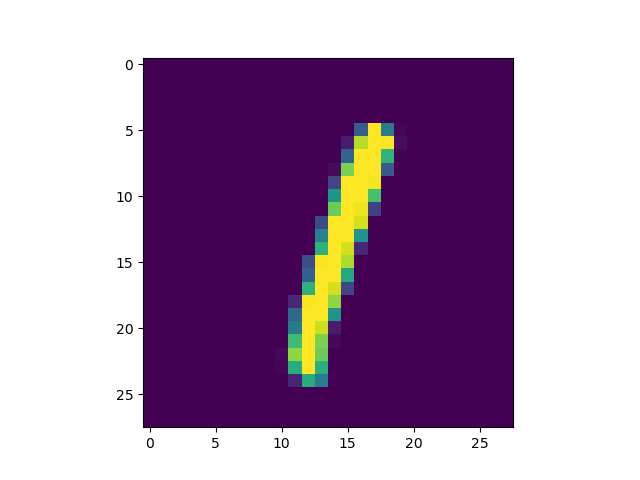

360
360
360
360
360
360
360
360
360
360
360
360
360
360
359
358
356
355
354
353
351
350
349
348
346
345
344
343
341
340
339
338
336
335
334
333
331
330
329
328
326
325
324
323
321
320
319
318
316
315
314
313
311
310
309
308
306
305
304
303
301
300
299
298
296
295
294
293
291
290
289
288
286
285
284
283
281
280
279
278
276
275
274
273
271
270
269
268
266
265
264
263
261
260
259
258
256
255
254
253
251
250
249
248
246
245
244
243
241
240
239
238
236
235
234
233
231
230
229
228
226
225
224
223
221
220
219
218
216
215
214
213
211
210
209
208
206
205
204
203
201
200
199
198
196
195
194
193
191
190
189
188
186
185
184
183
181
180
179
178
176
175
174
173
171
170
169
168
166
165
164
163
161
160
159
158
156
155
154
153
151
150
149
148
146
145
144
143
141
140
139
138
136
135
134
133
131
130
129
128
126
125
124
123
121
120
119
118
116
115
114
113
111
110
109
108
106
105
104
103
101
100
99
98
96
95
94
93
91
90
89
88
86
85
84
83
81
80
79
78
76
75
74
73
71
70
69
68
66
65
64
63
61
60
59
58
56
55
54
5

In [84]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

fig = plt.figure()
im = plt.imshow(digit_one.reshape(28,28), animated=True)
i=0
last = keep_state[-2]
first = keep_state[0]
def updatefig(*args):
    global i
    i += 1

    if(last):
        disp_state = last.pop()[0]
        print(disp_state)
    else:
        return 
    img = rotate_img(digit_one.reshape(28,28),disp_state)
    im.set_array(img)
    return im,

ani = FuncAnimation(fig, updatefig, interval=50, blit=True)
plt.show()

In [102]:
print(keep_state[-6])

[[77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], [114], [115], [116], [117], [118], [119], [120], [121], [122], [123], [124], [125], [126], [127], [128], [129], [130], [131], [132], [133], [134], [135], [136], [137], [138], [139], [140], [141], [142], [143], [144], [145], [146], [147], [148], [149], [150], [151], [152], [153], [154], [155], [156], [157], [158], [159], [160], [161], [162], [163], [164], [165], [166], [167], [168], [169], [170], [171], [172], [173], [174], [175], [176], [177], [178], [179], [180], [181], [182], [183], [184], [185], [186], [187], [188], [189], [190], [191], [192], [193], [194], [195], [196], [197], [198], [199], [200], [201], [202], [203], [204], [205], [206], [207], [208], [209], [210], [211], [212], [213], [214], [215], [216], [217], [218], [219], [220], [221], [222], 